Calculated on the [Summarization No Trainer](https://wandb.ai/muellerzr/summarization_no_trainer?workspace=user-muellerzr) logs stored in W&B, and then exported to CSV

Based on [this script](https://github.com/huggingface/brrr/blob/18455b79eda8cf0d4714c319657703b50bef1aea/benchmarks/megatron_lm/count_flops.py#L269-L274)

In [1]:
import pandas as pd

In [2]:
def get_flops_encoder_decoder(
    num_layers_enc,
    num_layers_dec,
    hidden_size,
    num_heads,
    vocab_size,
    seq_len_enc,
    seq_len_dec,
    kv_channels=None,
    ffn_hidden_size=None,
    attention_head_type="multihead",
    batch_size=1,
    recompute_granularity=None,
    glu_activation=False,
):
    """Counts flops in an encoder-decoder model
    Args:
        num_layers_enc: number of encoder layers
        num_layers_dec: number of decoder layers
        hidden_size: hidden size of the model
        num_heads: number of heads in the model
        kv_channels: hidden size of the key and value heads
        ffn_hidden_size: hidden size of the FFN
        vocab_size: size of the vocabulary
        seq_len_enc: sequence length of the encoder
        seq_len_dec: sequence length of the decoder
        batch_size: batch size
        attention_head_type: Type of attention head. Either "multihead" or "multiquery". Check https://github.com/bigcode-project/Megatron-LM for more info.
        recompute_granularity: Activation recomputation method. Either None, "full" or "selective". Check Megatron-LM docs for more info.
        glu_activation: Whether to use GLU activation in FFN. Check T5 v1.1 for more info.
    Returns:
        model_flops: flops in the model (should be independent of the hardware and model implementation)
        hardware_flops: flops in the hardware (actual flops performed on the hardware). Check 6.3 in https://arxiv.org/pdf/2205.05198.pdf
    """

    if kv_channels is None:
        assert hidden_size % num_heads == 0
        kv_channels = hidden_size // num_heads
    if ffn_hidden_size is None:
        ffn_hidden_size = 4 * hidden_size

    is_decoder_only = num_layers_dec == 0 and num_layers_enc > 0  # decoder-only has only "encoder" blocks

    # In the following we mark the reduced dimension with parentheses
    # encoder
    # self attention
    ## qkv projection
    if attention_head_type == "multihead":
        encoder_qkv_proj_flops_fwd = (
            2 * num_layers_enc * batch_size * seq_len_enc * (hidden_size) * 3 * num_heads * kv_channels
        )
    elif attention_head_type == "multiquery" and is_decoder_only:
        ## q projection
        encoder_q_proj_flops_fwd = (
            2 * num_layers_enc * batch_size * seq_len_enc * (hidden_size) * num_heads * kv_channels
        )
        ## kv projection -> In MultiQuery attention, keys and values are shared across heads
        encoder_kv_proj_flops_fwd = (
            2 * num_layers_enc * batch_size * seq_len_enc * (hidden_size) * 2 * kv_channels
        )  # TODO: check if we should mutliply by tp_size
        encoder_qkv_proj_flops_fwd = encoder_q_proj_flops_fwd + encoder_kv_proj_flops_fwd
    else:
        raise ValueError("Unknown attention head type: {}".format(attention_head_type))
    ## qk logits
    encoder_qk_logits_flops_fwd = (
        2 * num_layers_enc * batch_size * num_heads * seq_len_enc * (kv_channels) * seq_len_enc
    )
    ## v logits
    encoder_v_logits_flops_fwd = (
        2 * num_layers_enc * batch_size * num_heads * seq_len_enc * (seq_len_enc) * kv_channels
    )
    ## attn out
    encoder_attn_out_flops_fwd = (
        2 * num_layers_enc * batch_size * num_heads * seq_len_enc * (kv_channels) * hidden_size
    )
    # FF
    ## 1st layer
    encoder_ffn_1_flops_fwd = 2 * num_layers_enc * batch_size * seq_len_enc * (hidden_size) * ffn_hidden_size
    if glu_activation:
        # 3 matmuls instead of 2 in FFN
        # ref. https://arxiv.org/pdf/2002.05202.pdf
        # Used for example in T5 v1.1
        encoder_ffn_1_flops_fwd = 4 * num_layers_enc * batch_size * seq_len_enc * (hidden_size) * ffn_hidden_size
    ## 2nd layer
    encoder_ffn_2_flops_fwd = 2 * num_layers_enc * batch_size * seq_len_enc * (ffn_hidden_size) * hidden_size

    encoder_flops_fwd = (
        encoder_qkv_proj_flops_fwd
        + encoder_qk_logits_flops_fwd
        + encoder_v_logits_flops_fwd
        + encoder_attn_out_flops_fwd
        + encoder_ffn_1_flops_fwd
        + encoder_ffn_2_flops_fwd
    )

    # decoder
    # self attention
    ## qkv projection
    if attention_head_type == "multihead":
        decoder_self_qkv_proj_flops_fwd = (
            2 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * 3 * num_heads * kv_channels
        )
    elif attention_head_type == "multiquery" and not is_decoder_only:
        ## q projection
        decoder_self_q_proj_flops_fwd = (
            2 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * num_heads * kv_channels
        )
        ## kv projection -> In MultiQuery attention, keys and values are shared across heads
        decoder_self_kv_proj_flops_fwd = (
            2 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * 2 * kv_channels
        )
        decoder_self_qkv_proj_flops_fwd = decoder_self_q_proj_flops_fwd + decoder_self_kv_proj_flops_fwd
    else:
        raise ValueError("Unknown attention head type: {}".format(attention_head_type))
    ## qk logits
    decoder_self_qk_logits_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (kv_channels) * seq_len_dec
    )
    ## v logits
    decoder_self_v_logits_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (seq_len_dec) * kv_channels
    )
    ## attn out
    decoder_self_attn_out_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (kv_channels) * hidden_size
    )
    ## cross attention
    ## q projection
    decoder_cross_q_proj_flops_fwd = (
        2 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * num_heads * kv_channels
    )
    ## kv projection
    decoder_cross_kv_proj_flops_fwd = (
        2 * num_layers_dec * batch_size * seq_len_enc * (hidden_size) * 2 * num_heads * kv_channels
    )
    ## qk logits
    decoder_cross_qk_logits_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (kv_channels) * seq_len_enc
    )
    ## v logits
    decoder_cross_v_logits_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (seq_len_enc) * kv_channels
    )
    ## attn out
    decoder_cross_attn_out_flops_fwd = (
        2 * num_layers_dec * batch_size * num_heads * seq_len_dec * (kv_channels) * hidden_size
    )
    # FF
    ## 1st layer
    decoder_ffn_1_flops_fwd = 2 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * ffn_hidden_size
    if glu_activation:
        decoder_ffn_1_flops_fwd = 4 * num_layers_dec * batch_size * seq_len_dec * (hidden_size) * ffn_hidden_size
    ## 2nd layer
    decoder_ffn_2_flops_fwd = 2 * num_layers_dec * batch_size * seq_len_dec * (ffn_hidden_size) * hidden_size

    decoder_flops_fwd = (
        decoder_self_qkv_proj_flops_fwd
        + decoder_self_qk_logits_flops_fwd
        + decoder_self_v_logits_flops_fwd
        + decoder_self_attn_out_flops_fwd
        + decoder_cross_q_proj_flops_fwd
        + decoder_cross_kv_proj_flops_fwd
        + decoder_cross_qk_logits_flops_fwd
        + decoder_cross_v_logits_flops_fwd
        + decoder_cross_attn_out_flops_fwd
        + decoder_ffn_1_flops_fwd
        + decoder_ffn_2_flops_fwd
    )

    # lm head
    lm_head_flops_fwd = 2 * batch_size * seq_len_dec * (hidden_size) * vocab_size

    # the bwd pass requires double the flops in case of matmuls to calculate the gradients with respect to
    # both input and weight tensors
    model_flops = 3 * (encoder_flops_fwd + decoder_flops_fwd + lm_head_flops_fwd)  # 1 for fwd + 2 for bwd

    if recompute_granularity is None:
        hardware_flops = model_flops
    elif recompute_granularity == "full":
        # Note: we don't recompute lm head activs
        hardware_flops = model_flops + encoder_flops_fwd + decoder_flops_fwd  # + activ recomputation
    elif recompute_granularity == "selective":
        # all terms with s^2 are flops that are recomputed
        # ref. appendix A: https://arxiv.org/pdf/2205.05198.pdf
        recomputed_encoder_flops = encoder_qk_logits_flops_fwd + encoder_v_logits_flops_fwd
        recomputed_decoder_flops = (
            decoder_self_qk_logits_flops_fwd
            + decoder_self_v_logits_flops_fwd
            + decoder_cross_qk_logits_flops_fwd
            + decoder_cross_v_logits_flops_fwd
        )
        hardware_flops = model_flops + recomputed_encoder_flops + recomputed_decoder_flops
    else:
        raise ValueError("recompute_granularity must be one of 'full' or 'selective'")
    return model_flops

In [8]:
# This is a list of the first 100 output seq lengths from the dataset. 
output_seq_lengths = [128,109,119,128,94,128,125,128,128,128,75,96,113,74,109,128,106,94,128,99,118,90,81,92,126,100,116,123,128,128,121,123,87,95,128,118,128,104,128,109,128,127,99,98,87,128,109,128,128,128,99,83,128,114,114,117,128,79,128,128,128,84,128,96,81,103,100,128,82,87,128,101,111,128,128,83,113,86,128,85,112,118,128,104,76,128,128,111,128,109,128,101,123,125,120,118,124,98,109,86,91,128,110,128,107,100,104,103,102,128,98,128,109,128,93,86,73,111,128,128,104,98,128,79,128,128,128,104,105,85,110,98,97,101,77,82,124,95,128,120,84,93,128,87,128,120,109,100,114,128,128,100,71,116,94,111,105,127,87,93,86,96,128,79,79,118,128,128,128,114,104,100,109,128,128,128,106,106,109,112,128,128,128,128,97,128,128,128,109,128,128,121,96,112,127,128,85,100,94,109,90,99,110,119,113,105,128,128,128,128,128,126,128,96,128,128,80,72,128,128,128,92,91,106,97,104,123,128,91,97,99,89,125,80,128,128,128,119,128,84,128,95,113,87,115,128,128,115,109,128,128,90,84,128,88,100,128,96,89,81,100,86,106,126,128,118,89,91,106,128,128,117,127,128,128,82,128,108,128,108,106,128,124,115,128,128,126,84,93,96,81,79,114,128,94,119,81,80,128,91,128,99,114,68,128,103,104,128,128,91,128,108,128,125,128,128,105,105,96,110,128,128,95,97,122,109,128,88,102,118,128,128,82,128,128,113,128,128,73,128,128,128,85,94,128,128,128,98,128,128,128,92,100,127,124,128,109,116,128,128,122,98,122,124,108,128,128,92,128,126,92,128,66,128,125,128,128,101,97,103,128,128,98,128,88,128,88,128,85,95,120,128,101,96,105,94,128,128,128,128,128,85,84,86,83,90,100,96,120,88,128,98,85,128,110,103,128,86,102,102,108,108,104,127,128,128,97,128,119,84,128,77,128,128,111,128,115,66,112,110,128,128,121,109,105,103,128,111,128,109,114,112,123,128,86,128,128,102,122,88,104,128,84,128,94,93,128,122,106,71,128,92,128,111,81,109,128,112,128,94,128,109,85,117,87,111,73,121,86,111,91,96,128,87,128,95,102,98,128,128,111,94,115,111,93,117,118,128,128,128,128,127,128,107,112,128,128,128,128,89,85,103,116,109,128,96,98,82,128,84,89,102,128,128,128,96,128,118,86,83,79,128,127,95,128,112,94,106,99,121,109,86,128,78,93,128,128,92,128,86,102,128,100,109,128,99,86,128,76,104,109,96,81,128,97,128,128,128,110,112,93,118,128,105,128,87,72,85,128,125,110,87,123,128,111,128,97,126,128,123,125,114,100,89,128,97,97,123,128,90,128,78,119,118,101,126,71,112,121,98,99,110,128,128,128,128,101,128,83,111,128,128,128,90,125,114,83,96,100,106,113,128,75,108,128,97,128,128,127,128,85,128,128,108,107,94,77,116,117,121,88,122,128,88,128,91,102,89,128,127,124,102,113,128,128,112,100,128,97,128,101,128,85,128,126,128,96,128,119,82,87,87,92,104,103,123,82,104,128,106,89,95,107,96,128,95,69,85,96,122,78,128,128,106,128,128,86,128,110,73,128,120,93,128,128,116,100,106,128,79,128,128,128,105,100,94,128,78,128,128,101,104,128,74,83,112,100,125,104,128,128,128,105,101,105,95,128,127,128,74,103,84,100,128,128,128,128,105,128,128,100,128,128,128,112,128,97,124,119,88,83,97,96,128,92,98,99,128,93,79,128,128,128,88,118,121,97,98]

## 100_steps_bs_8

In [27]:
data = pd.read_csv("100_steps_bs_8.csv")
data = data[["Step", "baseline-100-steps-bs-8 - batch_time", "bf16-100-steps-bs-8 - batch_time", "fp8-100-steps-bs-8 - batch_time"]]
data.columns = ["step", "baseline_batch_time", "bf16_batch_time", "fp8_batch_time"]

In [28]:
data.columns = ["step", "baseline_batch_time", "bf16_batch_time", "fp8_batch_time"]

In [29]:
data.head()

,step,baseline_batch_time,bf16_batch_time,fp8_batch_time
0,0,1.465110,1.322873,3.075727
1,1,1.003993,0.993053,1.092488
2,2,1.009937,1.005595,0.800539
3,3,1.016116,1.013113,0.789967
4,4,0.992416,0.988785,0.784420


In [30]:
from functools import partial

In [31]:
calculate_flops = partial(
    get_flops_encoder_decoder,
    num_layers_enc=24,
    num_layers_dec=24,
    hidden_size=1024,
    num_heads=16,
    vocab_size=32128,
    kv_channels=64,
    ffn_hidden_size=4096,
    attention_head_type="multihead",
    batch_size=8*8,
    recompute_granularity=None,
    glu_activation=False,
)

In [32]:
for column in ["baseline_batch_time", "bf16_batch_time", "fp8_batch_time"]:
    new_column = column.replace("batch_time", "T_FLOPS")
    data[new_column] = data.apply(
        lambda x: (calculate_flops(seq_len_enc=1024, seq_len_dec=output_seq_lengths[x.name]) / (x[column] * 8 * 1e12)),
        axis=1
    )

In [33]:
data.head()

,step,baseline_batch_time,bf16_batch_time,fp8_batch_time,baseline_T_FLOPS,bf16_T_FLOPS,fp8_T_FLOPS
0,0,1.465110,1.322873,3.075727,15.361236,17.012892,7.317261
1,1,1.003993,0.993053,1.092488,22.010173,22.252634,20.227269
2,2,1.009937,1.005595,0.800539,22.092960,22.188356,27.871846
3,3,1.016116,1.013113,0.789967,22.148947,22.214607,28.489682
4,4,0.992416,0.988785,0.784420,21.943696,22.024280,27.762263


In [34]:
# Drop the first few rows for timing/initialization in the script
data = data[4:]

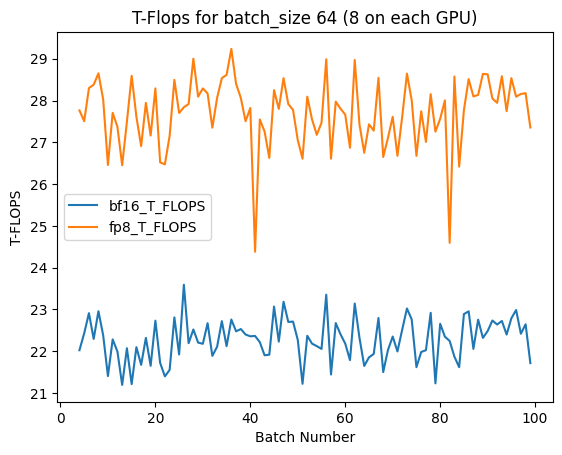

In [35]:
data[["bf16_T_FLOPS", "fp8_T_FLOPS"]].plot(
    title="T-Flops for batch_size 64 (8 on each GPU)",
    xlabel="Batch Number",
    ylabel="T-FLOPS"
).get_figure().savefig("100_steps_bs_8.png")

## 500_steps_bs_4

In [38]:
data = pd.read_csv("500_steps_bs_4.csv")
data = data[["Step", "baseline-500-steps-bs-4 - batch_time", "bf16-500-steps-bs-4 - batch_time", "fp8-500-steps-bs-4 - batch_time"]]
data.columns = ["step", "baseline_batch_time", "bf16_batch_time", "fp8_batch_time"]

In [39]:
data.head()

,step,baseline_batch_time,bf16_batch_time,fp8_batch_time
0,0,1.093010,1.195840,2.361911
1,1,0.649714,0.623457,0.739936
2,2,0.602640,0.585567,0.480447
3,3,0.618884,0.622609,0.506010
4,4,0.615849,0.610549,0.507237


In [40]:
data = data[1:]

In [41]:
calculate_flops = partial(
    get_flops_encoder_decoder,
    num_layers_enc=24,
    num_layers_dec=24,
    hidden_size=1024,
    num_heads=16,
    vocab_size=32128,
    kv_channels=64,
    ffn_hidden_size=4096,
    attention_head_type="multihead",
    batch_size=4*8,
    recompute_granularity=None,
    glu_activation=False,
)

In [42]:
for column in ["baseline_batch_time", "bf16_batch_time", "fp8_batch_time"]:
    new_column = column.replace("batch_time", "T_FLOPS")
    data[new_column] = data.apply(
        lambda x: (calculate_flops(seq_len_enc=1024, seq_len_dec=output_seq_lengths[x.name]) / (x[column] * 8 * 1e12)),
        axis=1
    )

In [43]:
data.head()

,step,baseline_batch_time,bf16_batch_time,fp8_batch_time,baseline_T_FLOPS,bf16_T_FLOPS,fp8_T_FLOPS
1,1,0.649714,0.623457,0.739936,17.005982,17.722193,14.932413
2,2,0.602640,0.585567,0.480447,18.512301,19.052050,23.220554
3,3,0.618884,0.622609,0.506010,18.182643,18.073857,22.238576
4,4,0.615849,0.610549,0.507237,17.680694,17.834163,21.466542
5,5,0.618314,0.608998,0.497283,18.199407,18.477814,22.628841


In [44]:
data = data[4:]

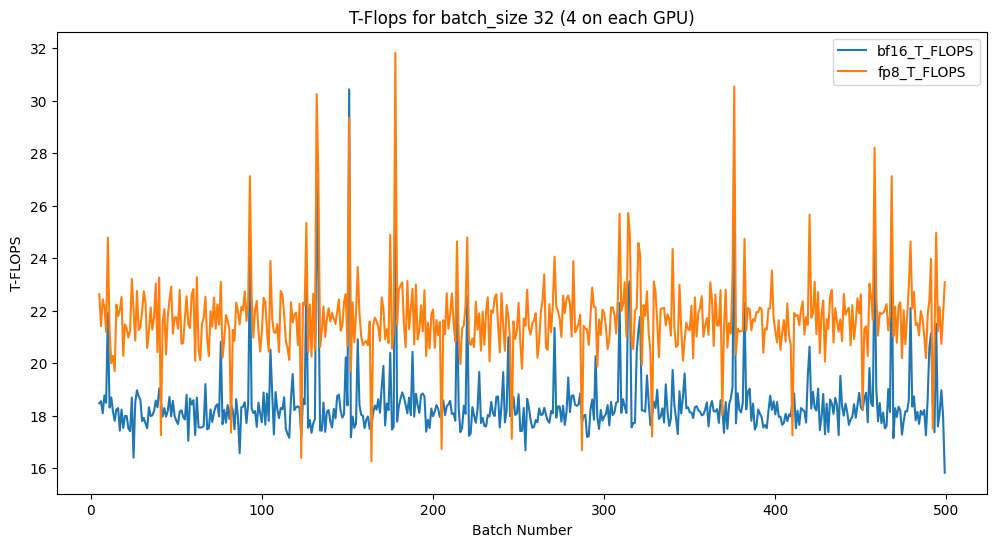

In [48]:
data[["bf16_T_FLOPS", "fp8_T_FLOPS"]].plot(
    title="T-Flops for batch_size 32 (4 on each GPU)",
    xlabel="Batch Number",
    ylabel="T-FLOPS",
    figsize=(12,6)
).get_figure().savefig("500_steps_bs_4.png")